# exploratory data analysis

In [1]:
import pandas as pd
pd.__version__
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style("whitegrid")
sns.despine()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

In [3]:
file = "../../nowdata/charters_2015.pkl"

import gc; gc.disable()
schooldf = pd.read_pickle(file)
gc.enable()

In [4]:
def convert_df(df):
    """Makes a Pandas DataFrame more memory-efficient through intelligent use of Pandas data types: 
    specifically, by storing columns with repetitive Python strings not with the object dtype for unique values 
    (entirely stored in memory) but as categoricals, which are represented by repeated integer values. This is a 
    net gain in memory when the reduced memory size of the category type outweighs the added memory cost of storing 
    one more thing. As such, this function checks the degree of redundancy for a given column before converting it.
    
    # TO DO: Filter out non-object columns, make that more efficient by downcasting numeric types using pd.to_numeric(), 
    merge  that with the converted object columns (see https://www.dataquest.io/blog/pandas-big-data/). 
    For now, since the current DF is ENTIRELY composed of object types, code is left as is. 
    But note that the current code will eliminate any non-object type columns."""
    
    converted_df = pd.DataFrame() # Initialize DF for memory-efficient storage of strings (object types)
    df_obj = df.select_dtypes(include=['object']).copy() # Filter to only those columns of object data type

    for col in df.columns: 
        if col in df_obj: 
            num_unique_values = len(df_obj[col].unique())
            num_total_values = len(df_obj[col])
            if (num_unique_values / num_total_values) < 0.5: # Only convert data types if at least half of values are duplicates
                converted_df.loc[:,col] = df[col].astype('category') # Store these columns as dtype "category"
            else: 
                converted_df.loc[:,col] = df[col]
        else:    
            converted_df.loc[:,col] = df[col]
                      
    converted_df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
    converted_df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='signed')
    
    return converted_df

In [5]:
def is_empty_list(series):
    """
    Args: Pandas Series of list
    Returns: a list contain Boolean value indicating whether the list is empty or not
    """
    lst = []
    for element in series:
        if len(element) == 0:
            lst.append(False)
        else:
            lst.append(True)
    return lst

## Setting stage for regressions

In [6]:
# Generate any new columns:
schooldf["DISC_RATIO"] = schooldf["DISCIPLINE_COUNT"]/schooldf["NUMWORDS"]
schooldf["INQ_RATIO"] = schooldf["INQUIRY_COUNT"]/schooldf["NUMWORDS"]
schooldf["ESS_RATIO"] = schooldf["ESS_COUNT"]/schooldf["NUMWORDS"]
schooldf["PROG_RATIO"] = schooldf["PROG_COUNT"]/schooldf["NUMWORDS"]

schooldf["% Population 25 Years and Over: Bachelor's Degree or Higher"] = schooldf["% Population 25 Years and Over: Bachelor's Degree"] + schooldf["% Population 25 Years and Over: Master's Degree"] + schooldf['% Population 25 Years and Over: Professional School Degree'] + schooldf['% Population 25 Years and Over: Doctorate Degree']
schooldf['% Total Population: Nonwhite'] = 1 - schooldf['% Total Population: White Alone']

In [7]:
# Clean up DF:
print("Initial length: ", len(schooldf))

schooldf = schooldf.drop_duplicates(subset=["NCESSCH"], keep='first') # Drop duplicate rows
schooldf = schooldf[schooldf["WEBTEXT"].apply(len) > 0] # Drop rows where NO WEBTEXT (0 pages) was gathered (i.e., scrape failed)
schooldf = schooldf[schooldf["WEBTEXT"].apply(lambda school: len(school[0][3])) > 0] # Drop rows where first scraped page is empty
schooldf = schooldf[schooldf["WEBTEXT"].apply(lambda school: sum([len(page[3]) for page in school])) > 0] # Drop rows where all pages are empty

# Drop rows where dictionary counting failed (yielding strengths = -6, the filler to avoid intractable infinity values):
#schooldf = schooldf[schooldf["DISC_STR"] != -6] 
#schooldf = schooldf[schooldf["INQU_STR"] != -6]
#schooldf = schooldf[schooldf["PROG_STR"] != -6]
#schooldf = schooldf[schooldf["ESS_STR"] != -6]

schooldf.drop(["WEBTEXT", "CMO_WEBTEXT"], axis=1, inplace=True) # Drop huge columns
schooldf = convert_df(schooldf) # Make DF more memory-efficient

print("Length after cleaning: ", len(schooldf))

Initial length:  12877
Length after cleaning:  6461


In [8]:
schooldf['constant'] = 1

controls = ['LEVEL', 'MEMBER', 'Population Density (Per Sq. Mile)', 'AGE'] # control variables. Could use 'LOCALE15' instead of pop density
IVs = ['PCTETH', 'PCTFRL', '% Total Population: Nonwhite', '% Families: Income in Below Poverty Level']

In [9]:
#data cleaning
#schooldf.dropna(axis = 0, how = 'any')
#schooldf = schooldf.loc[is_empty_list(schooldf['WEBTEXT']), :] #delete those with empty webtext

In [10]:
len(schooldf)

6461

In [11]:
schooldf.shape

(6461, 684)

In [12]:
list(schooldf.columns)

['NCESSCH',
 'CMO_NAME',
 'CMO_MEMSUM',
 'SCH_NAME',
 'CMO_STATE',
 'CMO_SCHNUM',
 'CMO_URL',
 'CMO_NUMSTATES',
 'CMO_ALLSTATES',
 'CMO_SECTOR',
 'CMO_NUMSTUDENTS_CREDO17',
 'CMO_TYPE',
 'SURVYEAR',
 'FIPST',
 'STABR',
 'SEANAME',
 'LEAID',
 'ST_LEAID',
 'SCHID',
 'ST_SCHID',
 'MSTREET1',
 'MSTREET2',
 'MSTREET3',
 'MCITY',
 'MSTATE',
 'MZIP',
 'MZIP4',
 'PHONE',
 'LSTREET1',
 'LSTREET2',
 'LSTREET3',
 'LCITY',
 'LSTATE',
 'LZIP',
 'LZIP4',
 'UNION',
 'OUT_OF_STATE_FLAG',
 'SCH_TYPE_TEXT',
 'SCH_TYPE',
 'RECON_STATUS',
 'GSLO',
 'GSHI',
 'LEVEL',
 'VIRTUAL',
 'BIES',
 'SY_STATUS_TEXT',
 'SY_STATUS',
 'UPDATED_STATUS_TEXT',
 'UPDATED_STATUS',
 'EFFECTIVE_DATE',
 'CHARTER_TEXT',
 'G13OFFERED',
 'AEOFFERED',
 'UGOFFERED',
 'NOGRADES',
 'CHARTAUTH1',
 'CHARTAUTHN1',
 'CHARTAUTH2',
 'CHARTAUTHN2',
 'IGOFFERED',
 'WEBSITE',
 'FRELCH',
 'REDLCH',
 'AE',
 'TOTAL',
 'AM',
 'AMALM',
 'AMALF',
 'AS',
 'ASALM',
 'ASALF',
 'HI',
 'HIALM',
 'HIALF',
 'BL',
 'BLALM',
 'BLALF',
 'WH',
 'WHALM',
 'WHAL

In [13]:
schooldf.to_csv("schooldf.csv", index = False)

# Regress on ESS_RATIO

In [78]:
# Regress '% Total Population: White Alone'
#         "% Population 25 Years and Over: Bachelor's Degree",
#         '% Civilian Population in Labor Force 16 Years and Over: Unemployed'
#         '% Families: Income in Below Poverty Level'
#         '% Total Population: Foreign Born'
#         'Population Density (Per Sq. Mile)'
#         'constant'
# On      'ESS_STR'  measurement of the magnitude of traditionism

OLS1_dta = schooldf[['ESS_RATIO'] + controls + IVs + ['constant']]

OLS1_dta = OLS1_dta.dropna(how = "any")

Y = OLS1_dta['ESS_RATIO']
X = OLS1_dta[controls + IVs + ['constant']]

results = sm.OLS(Y, X.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ESS_RATIO   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.745
Date:                Fri, 19 Oct 2018   Prob (F-statistic):             0.0836
Time:                        19:49:51   Log-Likelihood:                 9002.3
No. Observations:                2177   AIC:                        -1.799e+04
Df Residuals:                    2168   BIC:                        -1.794e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
LEVEL                                      3.772e-05   7.09e-05      0.532      0.595      -0.000       0.000
MEMBER                                     1.333e-08   1.61e-07      0.083      0.934   -3.03e-07    3.29e-07
Population Density (Per Sq. Mile)          3.277e-08   3.34e-08      0.982      0.326   -3.26e-08    9.82e-08
AGE                                       -3.435e-05   1.58e-05     -2.177      0.030   -6.53e-05   -3.41e-06
PCTETH                                        0.0004      0.000      0.924      0.355      -0.000       0.001
PCTFRL                                        0.0001      0.000      0.394      0.693      -0.001       0.001
% Total Population: Nonwhite              -8.306e-07   6.81e-06     -0.122      0.903   -1.42e-05    1.25e-05
% Families: Income in Below Poverty Level   6.07e-06   1.74e-05      0.348      0.728   -2.81e-05    4.03e-05
constant                                      0.0019      0.001      2.614      0.009       0.000       0.003
==============================================================================
Omnibus:                     4389.823   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18575463.130
Skew:                          15.848   Prob(JB):                         0.00
Kurtosis:                     454.417   Cond. No.                     3.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

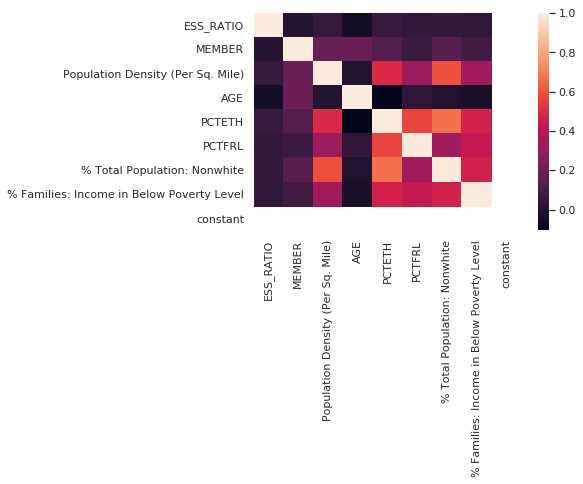

In [81]:
#check for multi-colinearity
corr = OLS1_dta.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

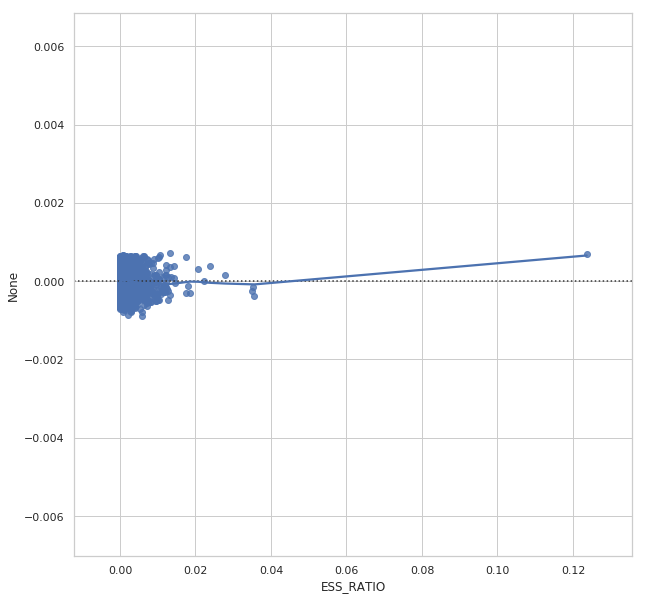

In [82]:
#check for heteroskedasticity
sns.set(style="whitegrid")
plt.figure(figsize = (10,10))
sns.residplot(Y, results.resid, lowess=True, color="b")

# Regress on PROG_RATIO

In [83]:
OLS2_dta = schooldf[['PROG_RATIO','% Total Population: White Alone',"% Population 25 Years and Over: Bachelor's Degree",\
            '% Civilian Population in Labor Force 16 Years and Over: Unemployed',\
            '% Families: Income in Below Poverty Level','% Total Population: Foreign Born',\
            'Population Density (Per Sq. Mile)', 'constant']]
OLS2_dta = OLS2_dta.dropna(how = "any")
Y2 = OLS2_dta['PROG_RATIO']
X2 = OLS2_dta[['% Total Population: White Alone',"% Population 25 Years and Over: Bachelor's Degree",\
            '% Civilian Population in Labor Force 16 Years and Over: Unemployed',\
            '% Families: Income in Below Poverty Level','% Total Population: Foreign Born',\
            'Population Density (Per Sq. Mile)', 'constant']]
results2 = sm.OLS(Y2, X2).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PROG_RATIO   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.983
Date:                Fri, 19 Oct 2018   Prob (F-statistic):           0.000569
Time:                        19:50:46   Log-Likelihood:                 9885.6
No. Observations:                2395   AIC:                        -1.976e+04
Df Residuals:                    2388   BIC:                        -1.972e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
% Total Population: White Alone                                    -6.948e-06   6.08e-06     -1.143      0.253   -1.89e-05    4.98e-06
% Population 25 Years and Over: Bachelor's Degree                   8.667e-06   1.71e-05      0.507      0.612   -2.48e-05    4.22e-05
% Civilian Population in Labor Force 16 Years and Over: Unemployed -2.899e-05    3.6e-05     -0.806      0.421   -9.95e-05    4.16e-05
% Families: Income in Below Poverty Level                          -1.338e-05   2.08e-05     -0.643      0.520   -5.42e-05    2.74e-05
% Total Population: Foreign Born                                   -2.964e-05    7.9e-06     -3.749      0.000   -4.51e-05   -1.41e-05
Population Density (Per Sq. Mile)                                   2.944e-09   3.57e-08      0.083      0.934    -6.7e-08    7.29e-08
constant                                                               0.0039      0.001      4.708      0.000       0.002       0.006
==============================================================================
Omnibus:                     2863.105   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           419601.019
Skew:                           6.174   Prob(JB):                         0.00
Kurtosis:                      66.657   Cond. No.                     4.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

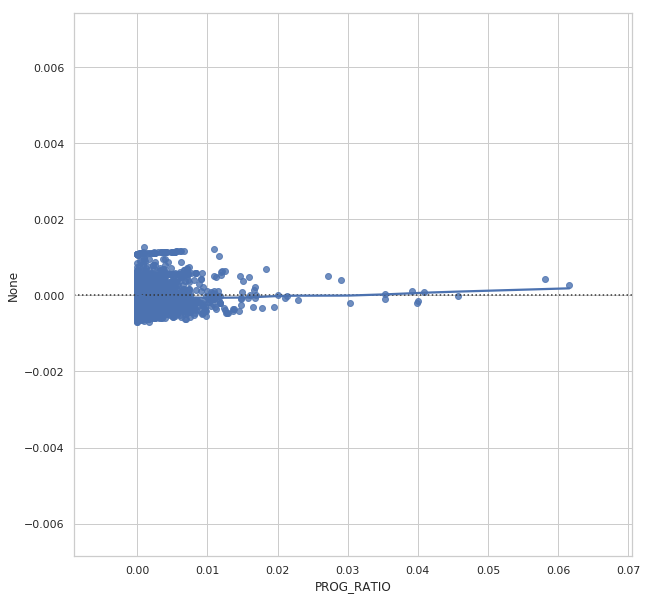

In [84]:
sns.set(style="whitegrid")
plt.figure(figsize = (10,10))
sns.residplot(Y2, results2.resid, lowess=True, color="b")

# Regress on INQ_RATIO and DISC_RATIO

In [69]:
OLS3_dta = schooldf[['INQ_RATIO', 'DISC_RATIO', 'STABR', 'LEAID'] + controls + IVs + ['constant']]

OLS3_dta = OLS3_dta.dropna(how = "any")

In [70]:
#OLS4_dta = schooldf[['INQ_RATIO'] + controls + IVs + ['constant']]
#OLS4_dta = OLS4_dta.dropna(how = "any")

Y3 = OLS3_dta['INQ_RATIO']
X3 = OLS3_dta[controls + IVs + ['constant']]
              
results3 = sm.OLS(Y3.astype(float), X3.astype(float)).fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              INQ_RATIO   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.918
Date:                Fri, 19 Oct 2018   Prob (F-statistic):           0.000131
Time:                        19:42:03   Log-Likelihood:                 6657.6
No. Observations:                2177   AIC:                        -1.330e+04
Df Residuals:                    2168   BIC:                        -1.325e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
LEVEL                                      1.228e-05      0.000      0.059      0.953      -0.000       0.000
MEMBER                                     3.006e-07   4.73e-07      0.635      0.526   -6.28e-07    1.23e-06
Population Density (Per Sq. Mile)         -4.692e-08   9.79e-08     -0.479      0.632   -2.39e-07    1.45e-07
AGE                                          -0.0002   4.63e-05     -4.187      0.000      -0.000      -0.000
PCTETH                                       -0.0019      0.001     -1.587      0.113      -0.004       0.000
PCTFRL                                        0.0012      0.001      1.185      0.236      -0.001       0.003
% Total Population: Nonwhite              -1.478e-05      2e-05     -0.740      0.460    -5.4e-05    2.44e-05
% Families: Income in Below Poverty Level   -6.8e-05   5.12e-05     -1.329      0.184      -0.000    3.24e-05
constant                                      0.0219      0.002     10.366      0.000       0.018       0.026
==============================================================================
Omnibus:                      473.592   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1193.598
Skew:                           1.170   Prob(JB):                    6.51e-260
Kurtosis:                       5.772   Cond. No.                     3.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

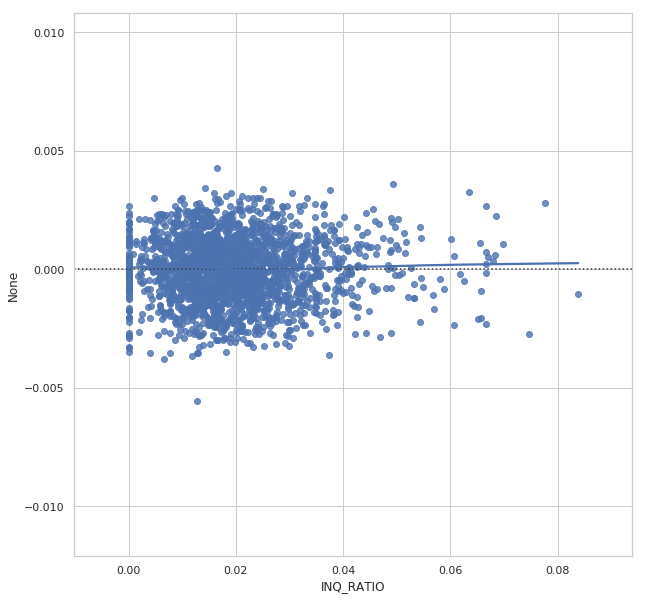

In [86]:
sns.set(style="whitegrid")
plt.figure(figsize = (10,10))
sns.residplot(Y3, results3.resid, lowess=True, color="b")

In [71]:
Y4 = OLS3_dta['DISC_RATIO']
X4 = OLS3_dta[controls + IVs + ['constant']]
              
results4 = sm.OLS(Y4.astype(float), X4.astype(float)).fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DISC_RATIO   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.229
Date:                Fri, 19 Oct 2018   Prob (F-statistic):           1.68e-09
Time:                        19:42:03   Log-Likelihood:                 8475.3
No. Observations:                2177   AIC:                        -1.693e+04
Df Residuals:                    2168   BIC:                        -1.688e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
LEVEL                                        -0.0004   9.03e-05     -4.251      0.000      -0.001      -0.000
MEMBER                                     8.647e-07   2.05e-07      4.211      0.000    4.62e-07    1.27e-06
Population Density (Per Sq. Mile)         -1.784e-07   4.25e-08     -4.198      0.000   -2.62e-07   -9.51e-08
AGE                                       -1.315e-05   2.01e-05     -0.655      0.513   -5.26e-05    2.63e-05
PCTETH                                        0.0010      0.001      1.909      0.056   -2.75e-05       0.002
PCTFRL                                     4.341e-05      0.000      0.103      0.918      -0.001       0.001
% Total Population: Nonwhite               -4.07e-06   8.67e-06     -0.469      0.639   -2.11e-05    1.29e-05
% Families: Income in Below Poverty Level  6.043e-05   2.22e-05      2.722      0.007    1.69e-05       0.000
constant                                      0.0028      0.001      3.074      0.002       0.001       0.005
==============================================================================
Omnibus:                     3353.642   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3174060.319
Skew:                           9.139   Prob(JB):                         0.00
Kurtosis:                     189.166   Cond. No.                     3.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

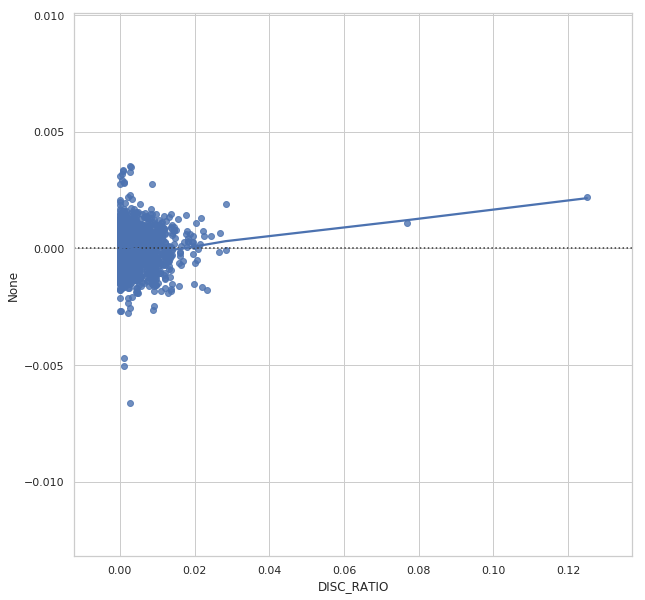

In [87]:
sns.set(style="whitegrid")
plt.figure(figsize = (10,10))
sns.residplot(Y4, results4.resid, lowess=True, color="b")

# Mixed models: Regress on INQ_RATIO and DISC_RATIO

In [72]:
# Regress on INQ_RATIO:
md =  sm.regression.mixed_linear_model.MixedLM(Y3.astype(float), X3.astype(float), groups=OLS3_dta['LEAID']).fit()
md.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                       MixedLM          Dependent Variable:          INQ_RATIO
No. Observations:            2177             Method:                      REML     
No. Groups:                  644              Scale:                       0.0001   
Min. group size:             1                Likelihood:                  6603.6233
Max. group size:             224              Converged:                   Yes      
Mean group size:             3.4                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
LEVEL                                     -0.000    0.000 -0.060 0.952 -0.000  0.000
MEMBER                                     0.000    0.000  0.385 0.700 -0.000  0.000
Population Density (Per Sq. Mile)          0.000    0.000  1.101 0.271 -0.000  0.000
AGE                                       -0.000    0.000 -3.767 0.000 -0.000 -0.000
PCTETH                                    -0.002    0.001 -1.478 0.139 -0.005  0.001
PCTFRL                                     0.001    0.001  1.454 0.146 -0.001  0.003
% Total Population: Nonwhite              -0.000    0.000 -0.771 0.441 -0.000  0.000
% Families: Income in Below Poverty Level -0.000    0.000 -0.303 0.762 -0.000  0.000
constant                                   0.021    0.003  7.517 0.000  0.015  0.026
Group Var                                  0.000    0.000                           
====================================================================================

"""

In [73]:
# Regress on DISC_RATIO:
md =  sm.regression.mixed_linear_model.MixedLM(Y4.astype(float), X4.astype(float), groups=OLS3_dta['STABR']).fit()
md.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          DISC_RATIO
No. Observations:           2177             Method:                      REML      
No. Groups:                 24               Scale:                       0.0000    
Min. group size:            3                Likelihood:                  8357.4253 
Max. group size:            885              Converged:                   No        
Mean group size:            90.7                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
LEVEL                                     -0.000    0.000 -3.839 0.000 -0.001 -0.000
MEMBER                                     0.000    0.000  4.001 0.000  0.000  0.000
Population Density (Per Sq. Mile)         -0.000    0.000 -3.784 0.000 -0.000 -0.000
AGE                                       -0.000    0.000 -0.384 0.701 -0.000  0.000
PCTETH                                     0.001    0.001  0.995 0.320 -0.001  0.002
PCTFRL                                     0.000    0.000  0.648 0.517 -0.001  0.001
% Total Population: Nonwhite               0.000    0.000  0.650 0.516 -0.000  0.000
% Families: Income in Below Poverty Level  0.000    0.000  1.932 0.053 -0.000  0.000
constant                                   0.004    0.002  2.276 0.023  0.000  0.007
Group Var                                  0.000                                    
====================================================================================

"""

In [74]:
len(OLS3_dta['STABR'].unique())
#sanity check, unique value in STABR

24

In [76]:
OLS3_dta[['INQ_RATIO']].head()

,INQ_RATIO
2,0.011976
3,0.023989
4,0.014060
8,0.024126
10,0.031551
